In [9]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow import keras

import joblib

import train_model

In [11]:
# load model
model_dIdV_exp = load_model("model_dIdV_exp.keras")
model_dIdV = load_model("model_dIdV.keras")
scaler_gamma = joblib.load('scaler_gamma.pkl')

In [12]:
# Load data
n12_chain_deconvolved = np.load('data_exp/12_site_deconv.npy').T

# Define parameters
num_sites = 12
res = 125
omega_values = np.linspace(10, 30, res)
omega_values_full = np.linspace(-50, 50, 500)

# Extract relevant data
exp_chain = n12_chain_deconvolved[:, 300:425].copy()

# Construct exp_chain efficiently
exp_chain = np.array([n12_chain_deconvolved[i, 300:425] * 0.75 for i in range(num_sites)]).reshape(1, -1)


## Helper functions

In [13]:
def averaged_predictions(length=12, n_data=1, res=125, data=exp_chain, model_ann=model_dIdV_exp):
    values_averaged = np.zeros((n_data, length * 2 - 1))
    
    # Onsite predictions
    for l in range(length - 4):
        pred_1, pred_2, pred_3 = (
            model_ann.predict(data[:, (l + i) * res : (3 * res) + (l + i) * res]) for i in range(3)
        )
        
        values_averaged[:, l + 2] = (pred_1[:, 2] + pred_2[:, 1] + pred_3[:, 0]) / 3
        
        if l == 0:
            values_averaged[:, l] = pred_1[:, 0]
            values_averaged[:, l + 1] = (pred_1[:, 1] + pred_2[:, 0]) / 2
        else:
            values_averaged[:, l + 3] = (pred_2[:, 2] + pred_3[:, 1]) / 2
            values_averaged[:, l + 4] = pred_3[:, 2]
    
    # Hopping predictions
    for l in range(length - 3):
        pred_1, pred_2 = (
            model_ann.predict(data[:, (l + i) * res : (3 * res) + (l + i) * res]) for i in range(2)
        )
        
        values_averaged[:, length + l + 1] = (pred_1[:, 4] + pred_2[:, 3]) / 2
        
        if l == 0:
            values_averaged[:, length + l] = pred_1[:, 3]
        else:
            values_averaged[:, length + l + 2] = pred_2[:, 4]
    
    return values_averaged


## Example prediction for an experimental chain of 12 CoPC molecules

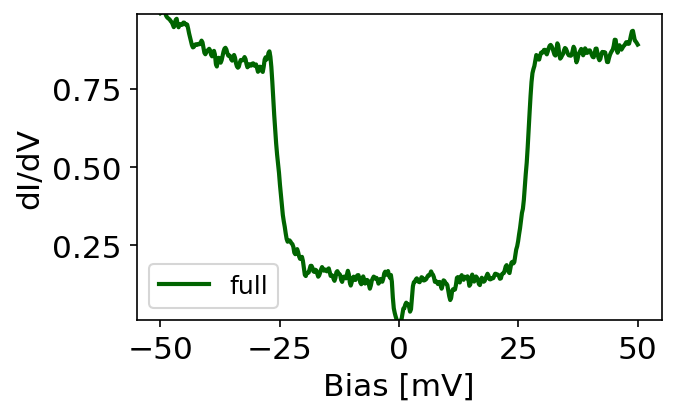

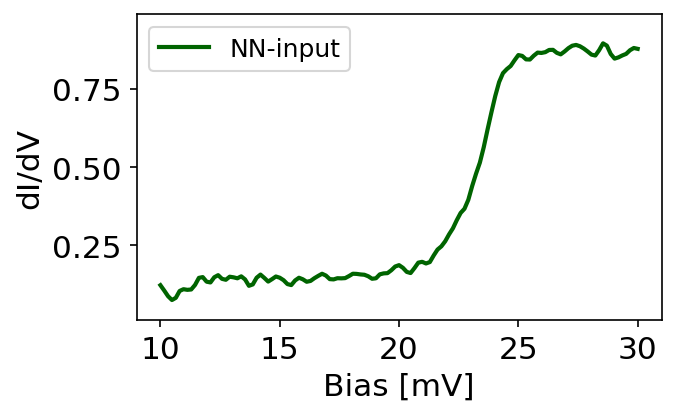

In [14]:
# Plot plot spectra
fig, ax = plt.subplots(dpi=150, figsize=(5, 3))
fig.subplots_adjust(0.2, 0.2)
plt.rcParams.update({'font.size': 15})
ax.plot(omega_values_full, n12_chain_deconvolved[2, 0:500], label='full', color='darkgreen', linewidth=2)
ax.set_xlabel("Bias [mV]")
ax.set_ylabel("dI/dV")
ax.set_ylim(0.01, 0.99)
ax.legend(fontsize=12)
plt.show()

# Plot plot spectra
fig, ax = plt.subplots(dpi=150, figsize=(5, 3))
fig.subplots_adjust(0.2, 0.2)
plt.rcParams.update({'font.size': 15})
ax.plot(omega_values, n12_chain_deconvolved[2, 300:425], label='NN-input', color='darkgreen', linewidth=2)
ax.set_xlabel("Bias [mV]")
ax.set_ylabel("dI/dV")
ax.set_ylim(0.01, 0.99)
ax.legend(fontsize=12)
plt.show()


In [ ]:
# Predict using model
pred_all_12 = [model_dIdV_exp.predict(exp_chain[:, l * res:375 + l * res]) for l in range(10)]

# Compute averaged predictions
averaged_n12 = averaged_predictions()


In [ ]:

label_rescaled = np.zeros((1, 12 * 2 - 1))
label_rescaled[:, :12] = averaged_n12[:, :12]
label_rescaled[:, 12:] = scaler_gamma.inverse_transform(averaged_n12[:, 12:])

print(label_rescaled)

data_onsite, data_hopping = averaged_n12[0, :12], averaged_n12[0, 12:]

# Ensure correct formatting of averaged predictions
averaged_n12_format = np.vstack([
    np.hstack((data_onsite[i:i+3], data_hopping[i:i+2])) for i in range(min(10, len(data_onsite) - 2))
])


[[1.15745926 1.07021868 1.19409513 1.19431245 1.17249262 1.15345335
  1.09430552 1.01590168 1.09010231 1.04502141 0.85827518 0.92823339
  0.2650375  0.22521569 0.17097109 0.14690407 0.18996981 0.25052334
  0.27051587 0.24947567 0.22324462 0.31061984 0.35074069]]
(10, 5)


ValueError: Found array with 0 feature(s) (shape=(10, 0)) while a minimum of 1 is required.

In [9]:
# Comparison of normal and averaged predictions
for i in range(len(averaged_n12_format)):
    print(f"Sample {i+1}:")
    print(f"Normal Prediction: {pred_all_12[i].flatten()}")
    print(f"Averaged Prediction: {averaged_n12_format[i]}")
    print("-" * 50)


Sample 1:
Normal Prediction: [1.1574593  1.0193033  1.1521909  0.6992022  0.57836807]
Averaged Prediction: [1.15745926 1.07021868 1.19409513 0.69920218 0.57975525]
--------------------------------------------------
Sample 2:
Normal Prediction: [1.121134  1.1819035 1.1351959 0.5811424 0.5336811]
Averaged Prediction: [1.07021868 1.19409513 1.19431245 0.57975525 0.45276099]
--------------------------------------------------
Sample 3:
Normal Prediction: [1.2481908  1.2247784  1.1727495  0.3718409  0.37728998]
Averaged Prediction: [1.19409513 1.19431245 1.17249262 0.45276099 0.37692761]
--------------------------------------------------
Sample 4:
Normal Prediction: [1.222963   1.225623   1.188551   0.37656528 0.40586287]
Averaged Prediction: [1.19431245 1.17249262 1.15345335 0.37692761 0.47747955]
--------------------------------------------------
Sample 5:
Normal Prediction: [1.1191052 1.17069   1.1247748 0.5490962 0.5963856]
Averaged Prediction: [1.17249262 1.15345335 1.09430552 0.4774795

## Example for N=40 simulation